In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
# HDBSCAN is New in version 1.3.
from sklearn.metrics import silhouette_score
#from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [3]:
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [4]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [5]:
## Pickle is theoretically faster for Python...

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\"
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")
start_time = time.time()

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

PCA_df = pd.read_pickle(data_path+'PCA_ms_IMUEMG_df.pkl')
metadata_cols_df = pd.read_pickle(data_path+'metadata_cols_df.pkl')

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

training_g_df = pd.read_pickle(data_path+'training_g_df.pkl').drop(metadata_cols, axis=1)
test_fullgestures_df = pd.read_pickle(data_path+'test_fullgestures_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.5802202224731445s


In [11]:
print(training_u_df.shape)
training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [12]:
print(test_users_df.shape)
test_users_df.head()

(99584, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
11520,0.068817,0.042105,-0.044102,0.053256,0.080938,0.106052,-0.022074,0.036360,-0.069783,-0.009365,...,0.063422,0.081947,0.101682,-0.190886,-0.128849,-0.133675,-0.141095,-0.068262,-0.032521,0.018558
11521,0.074061,0.047283,-0.042408,0.054238,0.074058,0.102463,-0.015359,0.038657,-0.073921,-0.017769,...,0.072693,0.087035,0.107107,-0.189667,-0.127273,-0.140950,-0.143033,-0.066269,-0.033821,0.018198
11522,0.079972,0.043184,-0.055275,0.046477,0.079097,0.100367,-0.017235,0.037957,-0.077119,-0.026219,...,0.071150,0.081851,0.103781,-0.186400,-0.119714,-0.137523,-0.143988,-0.064562,-0.036610,0.016388
11523,0.066582,0.035923,-0.040610,0.045127,0.083319,0.103084,-0.026479,0.037962,-0.074883,-0.020225,...,0.065488,0.077696,0.100158,-0.195122,-0.128462,-0.133530,-0.147047,-0.064546,-0.032468,0.015712
11524,0.070243,0.048672,-0.050055,0.045911,0.075328,0.102190,-0.026261,0.038253,-0.068708,-0.025581,...,0.064663,0.082686,0.104846,-0.185309,-0.126085,-0.138847,-0.147857,-0.067871,-0.031347,0.019686


In [13]:
print(training_g_df.shape)
training_g_df.head()

(383424, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [14]:
print(test_fullgestures_df.shape)
test_fullgestures_df.head()

(43328, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
11520,0.068817,0.042105,-0.044102,0.053256,0.080938,0.106052,-0.022074,0.036360,-0.069783,-0.009365,...,0.063422,0.081947,0.101682,-0.190886,-0.128849,-0.133675,-0.141095,-0.068262,-0.032521,0.018558
11521,0.074061,0.047283,-0.042408,0.054238,0.074058,0.102463,-0.015359,0.038657,-0.073921,-0.017769,...,0.072693,0.087035,0.107107,-0.189667,-0.127273,-0.140950,-0.143033,-0.066269,-0.033821,0.018198
11522,0.079972,0.043184,-0.055275,0.046477,0.079097,0.100367,-0.017235,0.037957,-0.077119,-0.026219,...,0.071150,0.081851,0.103781,-0.186400,-0.119714,-0.137523,-0.143988,-0.064562,-0.036610,0.016388
11523,0.066582,0.035923,-0.040610,0.045127,0.083319,0.103084,-0.026479,0.037962,-0.074883,-0.020225,...,0.065488,0.077696,0.100158,-0.195122,-0.128462,-0.133530,-0.147047,-0.064546,-0.032468,0.015712
11524,0.070243,0.048672,-0.050055,0.045911,0.075328,0.102190,-0.026261,0.038253,-0.068708,-0.025581,...,0.064663,0.082686,0.104846,-0.185309,-0.126085,-0.138847,-0.147857,-0.067871,-0.031347,0.019686


Let's actually re-arrange to make them 3D matrices...

In [6]:
num_rows_per_gesture = 64 # From the interp
num_gestures = len(PCA_df) // num_rows_per_gesture
num_features = PCA_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(PCA_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = PCA_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
PCA_np = data_np.reshape(num_gestures, num_rows_per_gesture, num_features)

#PCA_np = PCA_df.to_numpy()
flattened_PCA = PCA_np.reshape(num_gestures, -1)

Now proceed with the clustering

In [7]:
# Maximum number of components
max_clusters = 20 # Original dataset size

# Create a combined range: 2-20
num_clusters_range = list(range(2, max_clusters+1))

In [17]:
PCA_np.shape

(6668, 64, 40)

In [18]:
flattened_PCA.shape

(6668, 2560)

In [ ]:
# DO NOT RERUN THE BELOW!
assert(False)

In [19]:
## 4. Clustering and Classification Performance

# Clustering: Silhouette Score
kmeans_silhouette_scores = []
agglo_silhouette_scores = []

for n in num_clusters_range:
    start_time = time.time()
    
    print(f"{n}/{num_clusters_range[-1]}")    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans_labels = kmeans.fit_predict(flattened_PCA)
    print(f"KMeans Finished: {time.time() - start_time}")

    # Apply Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=n)
    agglo_labels = agglo.fit_predict(flattened_PCA)
    print(f"AggloClust Finished: {time.time() - start_time}")

    # Evaluate clustering with silhouette score
    kmeans_silhouette_scores.append(silhouette_score(flattened_PCA, kmeans_labels))
    agglo_silhouette_scores.append(silhouette_score(flattened_PCA, agglo_labels))
    print(f"Silhouette Finished: {time.time() - start_time}")
    
    print()

2/20
KMeans Finished: 2.86617112159729
AggloClust Finished: 60.148719787597656
Silhouette Finished: 61.935551404953

3/20
KMeans Finished: 65.24845242500305
AggloClust Finished: 122.24227833747864
Silhouette Finished: 124.01153802871704

4/20
KMeans Finished: 127.99683141708374
AggloClust Finished: 184.9999396800995
Silhouette Finished: 186.76287412643433

5/20
KMeans Finished: 191.88281345367432
AggloClust Finished: 248.8142123222351
Silhouette Finished: 250.56552481651306

6/20
KMeans Finished: 255.95372128486633
AggloClust Finished: 315.86540937423706
Silhouette Finished: 317.67026352882385

7/20
KMeans Finished: 323.7032868862152
AggloClust Finished: 382.0622751712799
Silhouette Finished: 383.8016896247864

8/20
KMeans Finished: 390.34604597091675
AggloClust Finished: 447.3701066970825
Silhouette Finished: 449.1175310611725

9/20
KMeans Finished: 455.30409264564514
AggloClust Finished: 512.2809126377106
Silhouette Finished: 513.9960556030273

10/20
KMeans Finished: 521.553328752517

Note from the above printouts that the trials take a while to run, although when it was originally run, the start_time was defined once, outside the loop, so all the above printed times are timed wrt a single start time (as opposed to a new start_time for each trial, as is currently in the code)

## Silhouette Scores
> 1 is the best, -1 is the worst, 0 indicates overlapping clusters. Negative means that a sample has been assigned to the wrong cluster, as a different cluster is more similar

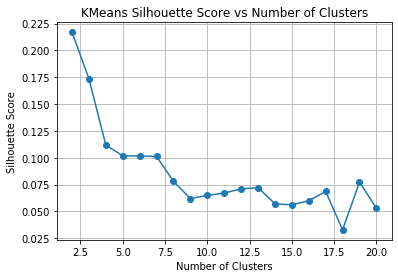

In [20]:
# Plot the silhouette scores
plt.plot(num_clusters_range, kmeans_silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

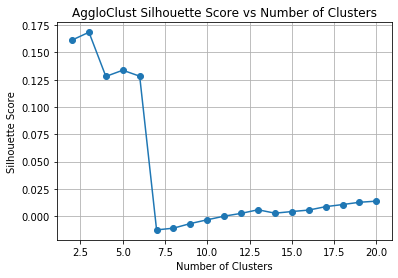

In [21]:
# Plot the silhouette scores
plt.plot(num_clusters_range, agglo_silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('AggloClust Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

> From the graphs above, the silhouette scores are not good (eg they are ~0.2, closer to 0 than to 1, indicating decent cluster overlap...

In [23]:
#import hdbscan
#HDBSCAN is an extension of DBSCAN that automatically determines the number of clusters and identifies noise points.
#It constructs a hierarchical clustering based on density and then extracts the clusters using a stable cut-off point.
#It's suitable for datasets with varying cluster densities and sizes.

# Create HDBSCAN object
#hdbscan = hdbscan.HDBSCAN(min_cluster_size=5)

# Fit the model and predict clusters
#clusters = hdbscan.fit_predict(flattened_PCA)

## Metrics That Don't Require Ground Truth Labels
- Silhouette Score: Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a higher score indicates better clustering.
- Davies–Bouldin Index: Represents the average similarity between each cluster and its most similar cluster, where lower values indicate better clustering.
- Calinski-Harabasz Index (Variance Ratio Criterion): Computes the ratio of the between-cluster dispersion to the within-cluster dispersion. Higher values indicate better clustering.
- Dunn Index: Measures the compactness and separation of clusters. It is the ratio of the smallest distance between observations not in the same cluster to the largest intra-cluster distance. Higher values are preferred.
- Gap Statistics: Measures the difference between the intra-cluster dispersion of the data and that expected under a null reference distribution. It helps in determining the optimal number of clusters.

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

def dunn_index(X, labels):
    # Compute pairwise distances between points in the same cluster
    intra_cluster_distances = []
    for cluster_label in np.unique(labels):
        cluster_points = X[labels == cluster_label]
        if len(cluster_points) > 1:
            nearest_neighbors = NearestNeighbors(n_neighbors=2).fit(cluster_points)
            distances, _ = nearest_neighbors.kneighbors()
            intra_cluster_distances.extend(distances[:, 1])

    # Compute pairwise distances between points in different clusters
    inter_cluster_distances = []
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            if labels[i] != labels[j]:
                inter_cluster_distances.append(np.linalg.norm(X[i] - X[j]))

    # Compute Dunn Index
    min_inter_cluster_distance = min(inter_cluster_distances)
    max_intra_cluster_distance = max(intra_cluster_distances)
    return min_inter_cluster_distance / max_intra_cluster_distance

def gap_statistics(X, labels):
    # Compute within-cluster dispersion
    Wk = np.sum([np.mean(np.linalg.norm(X[np.where(labels == k)] - np.mean(X[np.where(labels == k)], axis=0), axis=1)) for k in np.unique(labels)])

    # Generate reference datasets and compute within-cluster dispersion for each
    reference_Wk = []
    for i in range(10):
        random_data = np.random.rand(*X.shape)
        reference_labels = KMeans(n_clusters=len(np.unique(labels))).fit_predict(random_data)
        reference_Wk.append(np.sum([np.mean(np.linalg.norm(random_data[np.where(reference_labels == k)] - np.mean(random_data[np.where(reference_labels == k)], axis=0), axis=1)) for k in np.unique(reference_labels)]))
    
    # Compute Gap Statistics
    gap = np.mean(np.log(reference_Wk)) - np.log(Wk)
    return gap

def run_clustering_algorithm(clustering_algo_str, X, num_clusters=2, eps=0.5, min_samples=5):
    if clustering_algo_str == 'KMeans':
        model = KMeans(n_clusters=num_clusters, random_state=42)
    elif clustering_algo_str == 'DBSCAN':
        #It's suitable for datasets with complex cluster shapes and noise.
        #However, it may struggle with clusters of varying densities or high-dimensional data.
        #--> Probably both are true for us?...
        model = DBSCAN(eps=eps, min_samples=min_samples)
    elif clustering_algo_str == 'OPTICS':
        #It's suitable for datasets with varying cluster densities and non-convex shapes.
        #It can handle noise and doesn't require specifying the number of clusters in advance.
        model = OPTICS(eps=eps, min_samples=min_samples)

    labels = model.fit_predict(X)

    # Compute clustering metrics
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    di_index = dunn_index(X, labels)
    gap_stat = gap_statistics(X, labels)

    return silhouette, db_index, ch_index, di_index, gap_stat


In [15]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


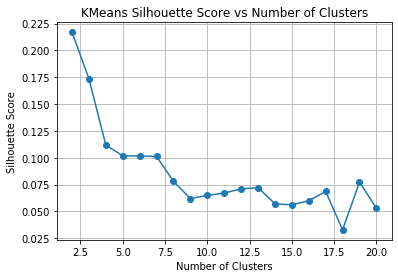

In [21]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

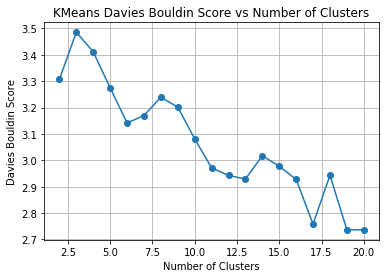

In [22]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

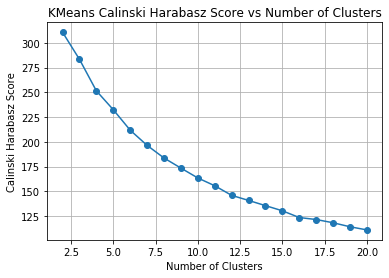

In [23]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

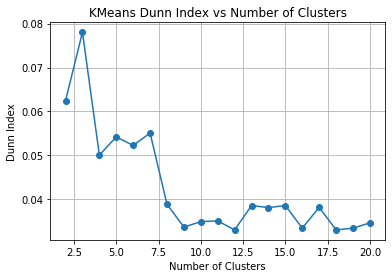

In [24]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

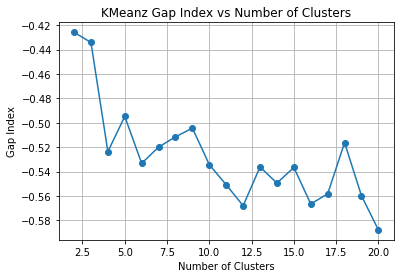

In [25]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

OPTICS doesnt wanna run, I didn't really look into what min_samples does or is supposed to be. Min_samples sets how many samples is required for a point to be its own centroid, I'm not sure why labels is only showing one class for OPTICS...

In [20]:
opt_silhouette_lst=[]
opt_davies_bouldin_lst=[]
opt_cali_har_lst=[]
opt_dunn_index_lst=[]
opt_gap_stat_lst=[]
# Eps is only used for DBSCAN, or when OPTICS uses DBSCAN for its clustering (it deosnt by default)
#eps_conditions=[0.1, 0.25, 0.5, 0.75, 1.0]
min_samples_conditions=[1,3,5,10]
#for ep in eps_conditions:
for ms in min_samples_conditions:
    print(f"min_samples={ms}") #eps={ep}, 
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('OPTICS', flattened_PCA, min_samples=ms) #eps=ep, 
    opt_silhouette_lst.append(silhouette)
    opt_davies_bouldin_lst.append(db_index)
    opt_cali_har_lst.append(ch_index)
    opt_dunn_index_lst.append(di_index)
    opt_gap_stat_lst.append(gap_stat)

min_samples=1


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## Dynamic Time Warping (DTW)
> Need to install some other package...

In [ ]:
#from tslearn.clustering import TimeSeriesKMeans
#from tslearn.metrics import dtw
#from tslearn.preprocessing import TimeSeriesScalerMeanVariance
#
## Scale the time series data
#scaler = TimeSeriesScalerMeanVariance()
#scaled_data = scaler.fit_transform(gestures_data)
#
## Apply KMeans with DTW as a metric
#dtw_kmeans = TimeSeriesKMeans(n_clusters=5, metric="dtw", random_state=42)
#dtw_labels = dtw_kmeans.fit_predict(scaled_data)
#
## Evaluate clustering with silhouette score
#dtw_silhouette = silhouette_score(scaled_data.reshape(num_gestures, -1), dtw_labels)
#
#print(f"DTW KMeans Silhouette Score: {dtw_silhouette}")

## Convolution Autoencoder
> Requires PyTorch, don't run this yet... we'll get to autoencoder later

In [ ]:
assert(1==0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Convert data to PyTorch tensors
gestures_data = torch.tensor(np.random.rand(100, 16, 64), dtype=torch.float32)

# Define the model
input_shape = (16, 64)  # Assuming input shape is channels x time_steps
autoencoder = Autoencoder(input_shape)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(gestures_data.transpose(1, 2))  # Transpose to match input shape
    loss = criterion(outputs, gestures_data.transpose(1, 2))  # Transpose back for loss calculation
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Extract encoder part
encoder = nn.Sequential(*list(autoencoder.encoder.children()))

# Encode the gestures
encoded_gestures = encoder(gestures_data.transpose(1, 2)).detach().numpy()  # Transpose for encoding
encoded_gestures_flattened = encoded_gestures.reshape(encoded_gestures.shape[0], -1)

# Perform clustering on the encoded data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_gestures_flattened)

# Evaluate clustering with silhouette score
kmeans_silhouette = silhouette_score(encoded_gestures_flattened, kmeans_labels)
print(f"KMeans Silhouette Score on Encoded Data: {kmeans_silhouette}")

## Choosing Optimal Number of Clusters

In [ ]:
assert(1==0)

> Elbow Plot

In [ ]:
from sklearn.cluster import KMeans

# determining the maximum number of clusters 
# using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)
 
# wcss - within cluster sum of squared distances
wcss = {}
 
for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    wcss[k] = model.inertia_
     
# plotting the wcss values to find the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

# determining the maximum number of clusters using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)

> Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    pred = model.predict(dataset_new)
    score = silhouette_score(dataset_new, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

# Archive

In [ ]:
assert(False)

This one takes forever to run, never even gets through the first trial with n=2 when running on the BRC desktop

In [ ]:
## Topological Measures: Neighborhood Preservation
# This one also uses an arbitrary number of clusters...

from sklearn.neighbors import NearestNeighbors

def knn_preservation_score(X_orig, X_reduced, k=5):
    num_gestures = X_orig.shape[0]
    flattened_orig = X_orig.reshape(num_gestures, -1)
    flattened_reduced = X_reduced.reshape(num_gestures, -1)
    
    knn_orig = NearestNeighbors(n_neighbors=k).fit(flattened_orig)
    knn_reduced = NearestNeighbors(n_neighbors=k).fit(flattened_reduced)
    neighbors_orig = knn_orig.kneighbors(flattened_orig, return_distance=False)
    neighbors_reduced = knn_reduced.kneighbors(flattened_reduced, return_distance=False)
    preservation = np.mean([len(set(neighbors_orig[i]).intersection(set(neighbors_reduced[i]))) / k for i in range(flattened_orig.shape[0])])
    return preservation

preservation_scores = []

# This is the full original file!
X = pd.read_pickle(data_path+'metadata_IMU_EMG_allgestures_allusers.pkl').drop(metadata_cols, axis=1).to_numpy()
X_reduced = PCA_df.to_numpy()

start_time = time.time()
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    # Needs full original dataset and then PCA reduced dataset
    score = knn_preservation_score(X, X_reduced, k=n)
    preservation_scores.append(score)
    print(f"Finished: {time.time() - start_time}")

# Plot the neighborhood preservation scores
plt.plot(components_range, preservation_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Neighborhood Preservation Score')
plt.title('Neighborhood Preservation vs Number of Clusters')
plt.grid(True)
plt.show()